In [10]:
import pandas as pd
import re
import numpy as np
import string
import nltk
import unidecode
from sklearn.feature_extraction import stop_words
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
import xgboost
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn import set_config
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
import random
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn import preprocessing
from collections import Counter
from bs4 import BeautifulSoup
import textstat
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv("datasets/disaster_tweets_train.csv",na_values=['',' ','nan'])
df_test=pd.read_csv("datasets/disaster_tweets_test.csv")

In [3]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df['keyword'].value_counts()

fatalities               45
armageddon               42
deluge                   42
damage                   41
harm                     41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [5]:
#only slightly imbalanced dataset, nothing major
(df['target'].value_counts()/len(df))*100 

0    57.034021
1    42.965979
Name: target, dtype: float64

In [173]:
#Explore the number of unique values for each feature
for col in df.columns:
    print(f'{col}: {df[col].nunique()} unique values')

id: 7613 unique values
keyword: 221 unique values
location: 3341 unique values
text: 7503 unique values
target: 2 unique values


In [4]:
#Checking columns with missing values
missing_prop=df.isna().sum()/len(df)
missing_prop[missing_prop>0].sort_values(ascending=False)

location    0.332720
keyword     0.008013
dtype: float64

In [100]:
df.shape

(7613, 5)

In [5]:
#replacing string with another string
df['keyword']=df['keyword'].replace(regex=[r'%20'], value='_')

# Feature engineering

In [6]:
sid=SentimentIntensityAnalyzer()

def doc_length(corpus):
    return np.array([len(doc)-doc.count(" ") for doc in corpus]).reshape(-1, 1)

def lexicon_count(corpus):
    return np.array([textstat.lexicon_count(doc,removepunct=True) for doc in corpus]).reshape(-1, 1)

def flesch_reading_ease(corpus):
    return np.array([textstat.flesch_reading_ease(doc) for doc in corpus]).reshape(-1, 1)

def automated_readability(corpus):
    return np.array([textstat.automated_readability_index(doc) for doc in corpus]).reshape(-1, 1)

def get_caps(doc):
    return sum([1 for char in doc if char.isupper()])

def count_capitalized(corpus):
    return np.array([get_caps(doc) for doc in corpus]).reshape(-1, 1)

def get_punctuation(doc):
    return sum([1 for char in doc if char in string.punctuation])

def count_punctuation(corpus):
    return np.array([get_punctuation(doc) for doc in corpus]).reshape(-1, 1)

def get_digit(doc):
    return sum([1 for char in doc if char.isdigit()])

def count_digit(corpus):
    return np.array([get_digit(doc) for doc in corpus]).reshape(-1, 1)

def num_exclamation_marks(corpus):
    return np.array([doc.count('!') for doc in corpus]).reshape(-1, 1)

def string_search(corpus):

    return np.array([bool(re.search("died|news|damage|#+S|@+S",doc.lower())) for doc in corpus]).reshape(-1, 1)

def extract_smile(corpus):
    return np.array([bool(re.search(":\)|:\(|;\)",doc.lower())) for doc in corpus]).reshape(-1, 1)


def sentiment(corpus):
    return np.array([sid.polarity_scores(doc)["compound"] for doc in corpus]).reshape(-1, 1)

def has_url(corpus):
    return np.array([bool(re.search("http", doc.lower())) for doc in corpus]).reshape(-1, 1)

In [7]:
#doing data preprocessing 
wn=nltk.WordNetLemmatizer()

from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()

def clean_text(text):
     # Remove HTML tags
        text = BeautifulSoup(text, ["lxml"]).get_text()
        
        text="".join([char.lower() for char in text if char not in string.punctuation]) 
        text= re.sub(r'\d+', '', text)
        
        #removing http: links
        text=re.sub(r'http\S+|www\S+', '', text).strip() 
        
        #tokenizing tweets
        token=tweet_tokenizer.tokenize(text) 
        text=[unidecode.unidecode(tokens) for tokens in token]
        text=" ".join([wn.lemmatize(word) for word in text])  
        return text

In [8]:
df.drop(["id","location"],inplace=True,axis=1)

X=df.drop('target',axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [9]:
categorical_features = df.select_dtypes(include=['object']).drop(['text'], axis=1).columns
categorical_features

Index(['keyword'], dtype='object')

In [11]:
# This vectorizer will be used to create the BOW features
vectorizer = TfidfVectorizer(preprocessor=clean_text, 
                             max_features = 1000, 
                             ngram_range=[1,4],
                             stop_words=None,
                             strip_accents="unicode",
                             lowercase=False,max_df=0.25, min_df=0.001,use_idf=True)


rf = RandomForestClassifier(criterion='entropy', random_state=42)

categorical_pipe=Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                           ('binary_encoder', ce.BinaryEncoder())
                          ])
#getting 'text' feature
text=df.columns[1] 

#moving vectorizer outside of FeatureUnion to be able to access features it creates for feature importance plot
tf_idf=Pipeline([('cv', vectorizer)])

feature_processing =FeatureUnion([        
    ('length', FunctionTransformer(doc_length, validate=False)),
    ('words', FunctionTransformer(lexicon_count, validate=False)),
    ('flesch_reading_ease',FunctionTransformer(flesch_reading_ease,validate=False)),
    ('automated_readability',FunctionTransformer(automated_readability,validate=False)),
    ('capital_count', FunctionTransformer(count_capitalized, validate=False)),  
    ('punc_count', FunctionTransformer(count_punctuation, validate=False)),
    ('digit_count', FunctionTransformer(count_digit, validate=False)),
    ('sentiment',FunctionTransformer(sentiment,validate=False)),
    ('has_url',FunctionTransformer(has_url,validate=False)),
    ('extract_smile',FunctionTransformer(extract_smile,validate=False)),
    ('string_search',FunctionTransformer(string_search,validate=False)),
    ('num_exclamation_marks',FunctionTransformer(num_exclamation_marks,validate=False))
 ])
 

preprocessor = ColumnTransformer(transformers=[('categorical', categorical_pipe, categorical_features),
                                               ('text', feature_processing, text),
                                               ('tf_idf_transform',tf_idf,text)])

pipe = Pipeline([('preprocessor', preprocessor),
#                  ('scaling',Normalizer()),
                 ('clf', rf)])

In [12]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('binary_encoder',
                                                                   BinaryEncoder())]),
                                                  Index(['keyword'], dtype='object')),
                                                 ('text',
                                                  FeatureUnion(transformer_list=[('length',
                                                                                  FunctionTransformer(func=<function doc_length at 0x0000026222DFAAF0>)...
                                                     

In [13]:
y_pred=pipe.predict(X_test)

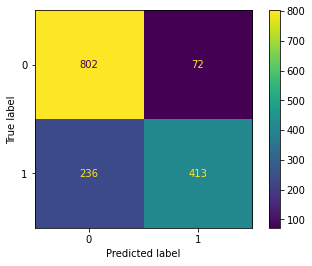

In [14]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipe, X_test, y_test)

In [15]:
from sklearn.metrics import precision_score,recall_score,f1_score

print(f'Precision: {precision_score(y_test,y_pred)}')

print(f'Recall: {recall_score(y_test,y_pred)}')

print(f'F1 Score: {f1_score(y_test,y_pred)}')

Precision: 0.8515463917525773
Recall: 0.6363636363636364
F1 Score: 0.728395061728395


In [16]:
import eli5

In [17]:
binaryencoded_columns=pipe.named_steps['preprocessor'].named_transformers_['categorical'].named_steps['binary_encoder'].get_feature_names()

binaryencoded_columns

['0_0', '0_1', '0_2', '0_3', '0_4', '0_5', '0_6', '0_7', '0_8']

In [18]:
text_features=['doc_length','lexicon_count','flesch_reading_ease','automated_readability','count_capitalized','count_punctuation',
              'count_digit','sentiment','has_url','string_search','extract_smile','num_exclamation_marks']

In [19]:
tf_idf_features=pipe.named_steps['preprocessor'].named_transformers_['tf_idf_transform'].named_steps['cv'].get_feature_names()

In [20]:
features=text_features+binaryencoded_columns+tf_idf_features

### Feature importance plot

In [22]:
eli5.explain_weights(pipe.named_steps['clf'], top=50, feature_names=features)

Weight,Feature
0.0385 ± 0.0227,0_4
0.0358 ± 0.0304,0_0
0.0342 ± 0.0243,num_exclamation_marks
0.0312 ± 0.0209,string_search
0.0309 ± 0.0201,0_1
0.0246 ± 0.0189,0_3
0.0218 ± 0.0156,0_2
0.0213 ± 0.0120,extract_smile
0.0188 ± 0.0124,in
0.0106 ± 0.0103,you


# GridSearch 

In [90]:
gb=xgboost.XGBClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42, n_estimators=200)

classifiers = {
     "RF": rf,
     "GBC": gb
}


model_results = list()
    
for model_name,model in classifiers.items():
            
    if model==rf:
         param_grid={"classifier__min_samples_leaf":[1,3,5],
                     "classifier__max_depth":[1,2,5,10,15,20],
                     "classifier__max_features":[1,5,15,20,17],
                     "classifier__n_estimators":[50,100,200,300]}


    elif model==gb:
        param_grid={"classifier__learning_rate":[0.2,0.3,0.4],
                    "classifier__max_depth":[1,5,10,15,20],
                    "classifier__n_estimators":[50,100,200,250]}

    pipe = Pipeline([('preprocessor', preprocessor),
#                  ('scaling',Normalizer()),
                 ('classifier', model)])

    

    CV = GridSearchCV(pipe, param_grid,cv=5, n_jobs= 1,verbose=True)
                  
    CV.fit(X_train, y_train)  
    print(CV.best_params_)    
    print(CV.best_score_)


Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed: 354.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('binary_encoder',
                                                                                          BinaryEncoder())]),
                                                                         Index(['keyword'], dtype='object')),
                                                                        ('text',
                                                                         F

{'classifier__max_depth': 20, 'classifier__max_features': 20, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 50}
0.7548440065681444
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 57.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('binary_encoder',
                                                                                          BinaryEncoder())]),
                                                                         Index(['keyword'], dtype='object')),
                                                                        ('text',
                                                                         F

{'classifier__learning_rate': 0.4, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}
0.7761904761904761


In [91]:
CV.refit

True

In [93]:
CV.predict(X_test)

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

### Stacking models

In [20]:
from sklearn.ensemble import StackingClassifier

base_models=[('rf',RandomForestClassifier(criterion='entropy', random_state=42)),
            ('gb',xgboost.XGBClassifier(random_state=42,learning_rate=0.4,max_depth=5,n_estimators=200)),
            ('dt',DecisionTreeClassifier(random_state=42))]

meta_model=LogisticRegression()

stacking_model=Pipeline([('preprocessor', preprocessor),
#                        ('scaling',Normalizer()),
                         ('clf', StackingClassifier(estimators=base_models,
                                                    final_estimator=meta_model,
                                                    passthrough=True,
                                                    cv=10))])

In [21]:
stacking_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('binary_encoder',
                                                                   BinaryEncoder())]),
                                                  Index(['keyword'], dtype='object')),
                                                 ('text',
                                                  FeatureUnion(transformer_list=[('length',
                                                                                  FunctionTransformer(func=<function doc_length at 0x000002C4F1AC7550>)...
                                                     

In [22]:
y_pred_stacking=stacking_model.predict(X_test)

## Working with test data

In [23]:
df_test=pd.read_csv("C:/Users/krist/Desktop/Python learning/Kaggle/disaster_tweets_test.csv")

In [24]:
#replacing string with another string
df['keyword']=df['keyword'].replace(regex=[r'%20'], value='_')

In [25]:
test_features=df_test[['keyword','text']]
test_features

,keyword,text
0,NaN,Just happened a terrible car crash
1,NaN,"Heard about #earthquake is different cities, s..."
2,NaN,"there is a forest fire at spot pond, geese are..."
3,NaN,Apocalypse lighting. #Spokane #wildfires
4,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...
3258,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,NaN,Storm in RI worse than last hurricane. My city...
3260,NaN,Green Line derailment in Chicago http://t.co/U...
3261,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [26]:
y_pred_stacking=stacking_model.predict(test_features)

In [27]:
my_submission_disaster = pd.DataFrame({'id': df_test.id, 'target': y_pred_stacking})
my_submission_disaster.head()
my_submission_disaster.to_csv('my_submission_tweetstacking.csv', index=False)

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
